# Resnet 50 model - CIFAR 100 Dataset

In this notebook, we train a Resnet 50 model on the CIFAR-100 dataset

## 1. Load dataset

The following code snippet will download the data, load it into memory, and convert pixel values to [0, 1].

In [12]:
from keras.datasets import cifar10

(X_train_temp, Y_train_temp), (X_test, Y_test) = cifar10.load_data()
#X_train_temp = X_train_temp.astype('float32') / 255 #Train_test set is 50,000 images   #change these lins to X_train_temp etc
#X_test = X_test.astype('float32') / 255


from sklearn.model_selection import train_test_split
X_train,X_validation,Y_train,Y_validation = train_test_split(X_train_temp, Y_train_temp, test_size = 0.2, random_state=0)

#X_validation = X_train[40000:]  #Validation set is 10,000 images
#Y_validation = Y_train[40000:]
#X_train = X_train[:40000]
#Y_train = Y_train[:40000]


# Convert pixel values data type to float32
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_validation = X_validation.astype('float32')

# Calculate the mean and standard deviation of the training images
import numpy as np
mean = np.mean(X_train)
std  = np.std(X_train)

# Normalize the data
# The tiny value 1e-7 is added to prevent division by zero
X_train = (X_train-mean)/(std+1e-7)
X_test  = (X_test-mean) /(std+1e-7)
X_validation = (X_validation-mean)/(std+1e-7)



print(X_train.shape, Y_train.shape)
print(X_validation.shape, Y_validation.shape)
print(X_test.shape, Y_test.shape)


(40000, 32, 32, 3) (40000, 1)
(10000, 32, 32, 3) (10000, 1)
(10000, 32, 32, 3) (10000, 1)


## 2. Show a few training examples and its label

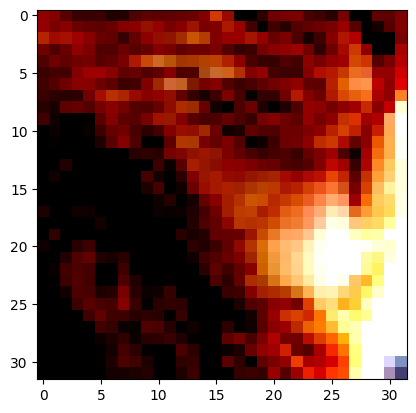

In [13]:
import matplotlib.pyplot as plt

# List of label strings for CIFAR10
#label_str = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

img_id = 0
image = X_train[img_id]
label = Y_train[img_id]

plt.imshow(image)
plt.show()
#print(label_str[label[0]])

Y_train2 = Y_train #Original arrays are needed later
Y_test2 = Y_test

In [14]:
from tensorflow.keras.utils import to_categorical

num_classes = 10
Y_train = to_categorical(Y_train, num_classes)
Y_test = to_categorical(Y_test, num_classes)


Y_validation2 = Y_validation
Y_validation = to_categorical(Y_validation, num_classes)

print(Y_train.shape, Y_test.shape) #so now each label is a binary one hot encoding array - 
print(Y_validation.shape)



(40000, 10) (10000, 10)
(10000, 10)


# Data Augmentation
To ensure the model generalizes well, we use data augmentation.

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(
    rotation_range=15,             # Rotate images randomly by up to 15 degrees        
    width_shift_range=0.12,         # Shift images horizontally by up to 12% of their width    
    height_shift_range=0.12,      # Shift images vertically by up to 12% of their height   
    horizontal_flip=True,     # Randomly flip images horizontally    
    zoom_range=0.1,           # Zoom images in by up to 10%  
    brightness_range=[0.9,1.1],     # Change brightness by up to 10%
    shear_range=10,             # Shear intensity (shear angle in counter-clockwise direction in degrees)
    channel_shift_range=0.1,      # Channel shift intensity
)


#When running the above code, we are setting up a pipeline for preprocessing the images during model training. 
#The generator applies a series of random transformations (specified by the parameters) to the images each time they are loaded into the model for training. 
#Each time an epoch is run during model training, these random transformations will create different variations of the original images. 
#These changes are made on-the-fly and don't modify our original dataset.


### 3. Define the Resnet-50 model

In [16]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, UpSampling2D

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tqdm.keras import TqdmCallback


resnet_base_model = ResNet50(weights=None, 
                          include_top=False, 
                          classes = 10,
                          input_shape=(32, 32, 3),
                          pooling='avg',
                            )

resnet_model = Sequential()
#resnet_model.add(UpSampling2D(size=(7, 7)))
resnet_model.add(resnet_base_model)

#resnet_model.add(GlobalAveragePooling2D())  # Add a global average pooling layer
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu')) # Add a fully connected layer
resnet_model.add(Dense(10, activation='softmax')) # Add the final output layer for classification




## 4. Compile the model

In [17]:
resnet_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
#Adam(learning_rate=0.001)
resnet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,641,930 (94.00 MB)

 Trainable params: 24,588,810 (93.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

## 5. Train the model

In [18]:
#mc = ModelCheckpoint('./weights.h5.keras', monitor='val_accuracy', save_best_only=True, mode='max')
 
#history = resnet_model.fit(
#    data_generator.flow(X_train, Y_train, batch_size=64),
#    epochs=100,
#    validation_data=(X_validation, Y_validation),
#    callbacks=[mc]
#    )    

from keras.callbacks import ReduceLROnPlateau, EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=1)

history = resnet_model.fit(data_generator.flow(X_train, Y_train, batch_size=128), 
          epochs=100, 
          validation_data = (X_validation, Y_validation),
          callbacks=[reduce_lr, early_stopping]
         )


#X_train, Y_train,
#batch_size=128, #batch size originally 32

#data_generator.flow(X_train, y_train, batch_size=batch_size),

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 108s 209ms/step - accuracy: 0.2447 - loss: 2.4515 - val_accuracy: 0.3752 - val_loss: 1.7277 - learning_rate: 0.0010
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 124ms/step - accuracy: 0.4311 - loss: 1.5629 - val_accuracy: 0.4872 - val_loss: 1.4400 - learning_rate: 0.0010
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 124ms/step - accuracy: 0.4926 - loss: 1.4081 - val_accuracy: 0.4721 - val_loss: 1.7108 - learning_rate: 0.0010
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 126ms/step - accuracy: 0.5016 - loss: 1.3770 - val_accuracy: 0.5354 - val_loss: 1.3417 - learning_rate: 0.0010
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 126ms/step - accuracy: 0.5350 - loss: 1.2954 - val_accuracy: 0.5823 - val_loss: 1.1662 - learning_rate: 0.0010
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 125ms/step - accuracy: 0.5698 - loss: 1.1975 - val_accuracy: 0.5849 - val_loss: 1.1527 - learning_rate: 0.0010
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 127ms/step - accur

# Save the model
Save the ResNet-50 model for later use

In [19]:
# Save the model
resnet_model.save('/kaggle/working/Data_Augmentation_ResNet50_100epoch.h5')

#reload best model

#best_val_model = resnet_model

#best_val_model.load_weights('/kaggle/working/weights.h5.keras')

## 6. Evaluate the trained model on test set

In [20]:
accuracy = resnet_model.evaluate(X_test, Y_test)[1]
print(accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8336 - loss: 0.5089
0.8364999890327454


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8336 - loss: 0.5089
0.8364999890327454


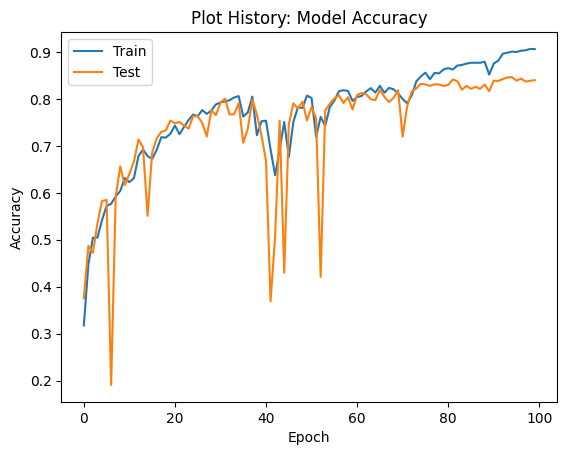

In [21]:
accuracy = resnet_model.evaluate(X_test, Y_test)[1]
print(accuracy)

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Plot History: Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

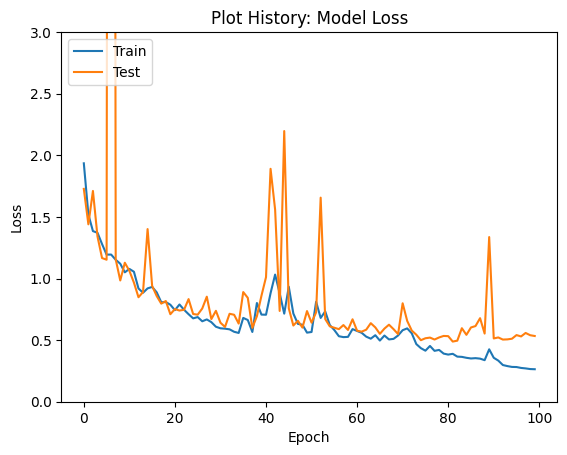

In [23]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.title('Plot History: Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.ylim(0, 3)
plt.show()


# Show a Test Example and the Model predicition

In [ ]:
# Printing a test image and seeing what the model thinks it is

test_img_id = 1
test_image1 = X_test[test_img_id]
test_label1 = Y_test2[test_img_id]

plt.imshow(test_image1)  #Show image
plt.show()
print("Test Index_Id: ", test_img_id)
print("True Label: ", label_str[test_label1[0]])

# Print model predicted label and the models confidence                 
model_label_index = (resnet_model.predict(X_test[test_img_id:test_img_id+1])).argmax()  #Essentially just finding all probs for all classes then picking the index location of the maximum and its corresponding label
model_label_confidence = (resnet_model.predict(X_test[test_img_id:test_img_id+1])).max()

print("Model Label and Associated Confidence: ", [label_str[model_label_index], model_label_confidence])

# Model Evaluation
Now that we have a model, we can begin to evaluate it. We begin by comparing the average confidence and accuracy

In [ ]:
#We now want the average confidence of the max confidence                                                 #This part is just an overlook, not specific to the research documents
a = resnet_model.predict(X_test[0:])                                                                     #All models predictions, with probablitly/confidence array for each test sample
b = a.max(axis = 1, keepdims = False)                                                             # All confidences of model prediction on test set (on its predicted/max label)
print("Average confidence of model over whole test set is:", b.mean())                            #Miscalibration, not ECE
print("Recall, the Accuracy on Test set was: ", accuracy)

#So on the test set the model is overconfident hence we need it to be recalibrated

# Define an Expected Calibration Error (ECE) function
The ECE is a common method to evaluate the performance of the model. Lower ECE's are better.

In [ ]:
import numpy as np

def calculateECE(NumBins, X, Y, calibratedprobs = -999):
    """
    This function calculates the ECE on data provided.
    -NumBins is defined to be equal width intervals e.g. if NumBins = 10, 
                 then the intervals are: [0,0.1), [0,1,0.2) etc
    """

    if type(calibratedprobs) == type(np.array([0])):
        modelPredictX = calibratedprobs        
    else:
        modelPredictX = resnet_model.predict(X[0:])
        
    predictions_probs_arrays = modelPredictX                                               #All models predictions_probs, with probablitly/confidence array for each test sample
    prediction_prob_of_max = predictions_probs_arrays.max(axis = 1, keepdims = False)                   # All confidences of model prediction on test set (on its predicted/max label)
    
    #Calculating ECE by splitting into M equal width bins, e.g. could split into 10 bins, (0, 0.1],(0.1,0.2], ... (0.9,1]
    indices_for_each_Bm = [np.array(np.where((prediction_prob_of_max>i) & (prediction_prob_of_max<= i + (1/NumBins)))[0]) for i in (np.linspace(0,1,NumBins+1))[0:-1]]   #-1 here?               #All indices for each confidence Bm interval from e.g. (0,0.1],(0.1,0.2], ..., (0.9,1] in here, each as its own list/array 
    labelType = (Y == modelPredictX.argmax(axis = 1, keepdims = True)).reshape(1,-1)[0]                      #All correct label predicts by model. (Array of whether the model predicts correctly or incorrectly for all the X_test data samples)
    label_type_for_each_Bm = [labelType[indices_for_each_Bm[count]] for count in range(0,NumBins,1)]                        #Whether the model was correct or incorrect for each sample now split by confidence Bm Interval

    #Calculate accuracy and confidence for each bin interval
    accuracy_for_each_Bm = [label_type_for_each_Bm[count].mean() for count in range(0,NumBins,1)]                  #Accuracy for each confidence Bm interval - acc(Bm)
    confidence_for_each_Bm = [prediction_prob_of_max[indices_for_each_Bm[count]].mean() for count in range(0,NumBins,1)]                  # Avg confidence for each Bm confidence interval - conf(Bm)

    #Put together to get the ECE
    temp = [abs(accuracy_for_each_Bm[count]-confidence_for_each_Bm[count])*len(indices_for_each_Bm[count]) for count in range(0,NumBins,1)]
    ECE = (1/len(Y)) * np.nansum(temp)
    
    return ECE

#Example
ECE12bins = calculateECE(12, X_test, Y_test2)  #IMPERATIVE TO USE Y_TEST2 HERE BECAUSE Y_TEST IS ONE HOT ENCODING #Genuine #Also don't rerun Y_test2 = command
print("ECE is:", ECE12bins)

# Plot an accuracy vs confidence plot
To better understand if the model is generating correct confidences we will plot a confidence vs true accuracy plot and compare to the identity function. Note that the identity function (y=x) is the target.

In [ ]:
#Calculating values for the plot
#We will split into 10 equal width bins
NumBins = 10
ResnetModelPredictXtest = resnet_model.predict(X_test[0:])

predictions_probs_arrays = ResnetModelPredictXtest
prediction_prob_of_max = predictions_probs_arrays.max(axis = 1, keepdims = False)
    

indices_for_each_Bm = [np.array(np.where((prediction_prob_of_max>i) & (prediction_prob_of_max<= i + (1/NumBins)))[0]) for i in (np.linspace(0,1,NumBins+1))[0:-1]]                  
labelType = (Y_test2 == ResnetModelPredictXtest.argmax(axis = 1, keepdims = True)).reshape(1,-1)[0]                      
label_type_for_each_Bm = [labelType[indices_for_each_Bm[count]] for count in range(0,NumBins,1)]                        

    #Calculate accuracy and confidence for each bin interval
accuracy_for_each_Bm = [label_type_for_each_Bm[count].mean() for count in range(0,NumBins,1)]  #acc(Bm)
confidence_for_each_Bm = [prediction_prob_of_max[indices_for_each_Bm[count]].mean() for count in range(0,NumBins,1)] #conf(Bm)

#Remove NaN values
acc_Bm_no_NaN = [val for val in accuracy_for_each_Bm if str(val) != 'nan']
conf_Bm_no_NaN = [val2 for val2 in confidence_for_each_Bm if str(val2) != 'nan']

#Plot confidence of model vs accuracy of model
plt.plot(conf_Bm_no_NaN, acc_Bm_no_NaN, color = 'red')
plt.plot([0,1], [0,1], color ='black', linestyle = '--', zorder = 0) #[x0,x1], [y0,y1]
plt.title("Resnet50 Model Confidences vs Accuracies  plot")
plt.legend(('Resnet50 Model','target'),loc=0)
plt.xlabel("Confidence")
plt.ylabel("Accuracy")

# Create an NLL calculation function
Minimising the NLL is a common technique in many post calibration methods

In [ ]:
def calculateNLL(X, Y, calibratedprobs = -999):
    """
    This function calculates the NLL on data provided.

    """

    if type(calibratedprobs) == type(np.array([0])):
        modelPredictX = calibratedprobs        
    else:
        modelPredictX = resnet_model.predict(X[0:])
        
    predictions_probs_arrays = modelPredictX

    #We need the confidence/prediction prob on the correct label
    #print(predictions_probs_arrays)
    
    prediction_prob_of_correct = predictions_probs_arrays[np.arange(len(Y)), Y.reshape((1,-1))[0]] # Take the prediction prob of the correct label for each
    log_prediction_prob_of_correct = np.log(prediction_prob_of_correct)
    NLL = -sum(log_prediction_prob_of_correct)

    return NLL


a = calculateNLL(X_train, Y_train2)
a1dot2 = calculateNLL(X_train[0:10000], Y_train2[0:10000])
b = calculateNLL(X_validation, Y_validation2)
c = calculateNLL(X_test, Y_test2)
print(a)
print(a1dot2)
print(b)
print(c)


# Apply Temperature Scaling
To calibrate the model, we will apply temperature scaling to ensure that the model confidences are approximately equal to the true likelihood that the predicted label is correct. To do this we will find the optimal value of T that minimizes the NLL on the validation set.

In [ ]:
import tensorflow as tf

def temperature_scaling(logits, temperature):
    scaled_logits = logits / temperature
    calibrated_probs = tf.nn.softmax(scaled_logits).numpy()
    return calibrated_probs


#Compute NLL on validation set using T temperature scaling

logits = np.log(resnet_model.predict(X_validation))    #Define outside function
NLLmin = 9999999999999999999999
correspondingT = -99997
def temp(T):
    """ T is the temperature """
    global NLLmin
    global correspondingT

    calibrated_probs_x_validation = temperature_scaling(logits, T)
    
    NLL_update = calculateNLL("tempvalx", Y_validation2, calibrated_probs_x_validation)
    if NLL_update < NLLmin: #Lower NLL better
        NLLmin = NLL_update
        correspondingT = T
        print("NLL on validation set for T = ", T, " is:", NLL_update)
    return NLL_update

#minimize NLL
from scipy.optimize import minimize
minimize(temp, 1)


# Now we can see how this affects the ECE for a chosen number of bins
logits_x_test = np.log(resnet_model.predict(X_test))
calibrated_probs_x_test = temperature_scaling(logits_x_test, correspondingT)
print("On the Validation set: Optimal T is", correspondingT, "And using this T value to calculate the ECE (10bins) on the test set gives: ", calculateECE(10, "X_test", Y_test2, calibrated_probs_x_test))        #Renote ECE(..,..,YTEST222222222 )
print("Remember that the ECE (10bins) using the standard T=1 (uncalibrated) was", calculateECE(10, X_test, Y_test2))
#Note find an appropriate temperature using the validation set before reevaluating the model on the test set
#NOTE COULD PROVE HERE THAT THE CONSTANT OF LOG FOR SOFTMAX DOES NOT AFFECT THE RESULT FOR DIFFERENT T
#Evaluate the calibration performance using metrics like ECE and confidence Bm vs accuracy Bm plots AND MORE R-SQUARED - CONFUSION MATRIX?

# Retest the Accuracy vs Confidence plot on the calibrated model*
Same as before but now we can use the temperature scaled model*

In [ ]:
#Calculating values for the plot
#We will split into 10 equal width bins
NumBins = 10
#1
#ResnetModelPredictXtest from earlier
predictions_probs_arrays = ResnetModelPredictXtest 
prediction_prob_of_max = predictions_probs_arrays.max(axis = 1, keepdims = False)
indices_for_each_Bm = [np.array(np.where((prediction_prob_of_max>i) & (prediction_prob_of_max<= i + (1/NumBins)))[0]) for i in (np.linspace(0,1,NumBins+1))[0:-1]]                  
labelType = (Y_test2 == ResnetModelPredictXtest .argmax(axis = 1, keepdims = True)).reshape(1,-1)[0]                      
label_type_for_each_Bm = [labelType[indices_for_each_Bm[count]] for count in range(0,NumBins,1)]                        
    #Calculate accuracy and confidence for each bin interval
accuracy_for_each_Bm = [label_type_for_each_Bm[count].mean() for count in range(0,NumBins,1)]  #acc(Bm)
confidence_for_each_Bm = [prediction_prob_of_max[indices_for_each_Bm[count]].mean() for count in range(0,NumBins,1)] #conf(Bm)
#Remove NaN values
acc_Bm_no_NaN1 = [val for val in accuracy_for_each_Bm if str(val) != 'nan']
conf_Bm_no_NaN1 = [val2 for val2 in confidence_for_each_Bm if str(val2) != 'nan']


#2
NewModelPredictX = calibrated_probs_x_test
Y = Y_test2
        
predictions_probs_arrays = NewModelPredictX                                               #All models predictions_probs, with probablitly/confidence array for each test sample
prediction_prob_of_max = predictions_probs_arrays.max(axis = 1, keepdims = False)                   # All confidences of model prediction on test set (on its predicted/max label)
    
#Calculating ECE by splitting into M equal width bins, e.g. could split into 10 bins, (0, 0.1],(0.1,0.2], ... (0.9,1]
indices_for_each_Bm = [np.array(np.where((prediction_prob_of_max>i) & (prediction_prob_of_max<= i + (1/NumBins)))[0]) for i in (np.linspace(0,1,NumBins+1))[0:-1]]   #-1 here?               #All indices for each confidence Bm interval from e.g. (0,0.1],(0.1,0.2], ..., (0.9,1] in here, each as its own list/array 
labelType = (Y == NewModelPredictX.argmax(axis = 1, keepdims = True)).reshape(1,-1)[0]                      #All correct label predicts by model. (Array of whether the model predicts correctly or incorrectly for all the X_test data samples)
label_type_for_each_Bm = [labelType[indices_for_each_Bm[count]] for count in range(0,NumBins,1)]                        #Whether the model was correct or incorrect for each sample now split by confidence Bm Interval

#Calculate accuracy and confidence for each bin interval
accuracy_for_each_Bm = [label_type_for_each_Bm[count].mean() for count in range(0,NumBins,1)]                  #Accuracy for each confidence Bm interval - acc(Bm)
confidence_for_each_Bm = [prediction_prob_of_max[indices_for_each_Bm[count]].mean() for count in range(0,NumBins,1)]                  # Avg confidence for each Bm confidence interval - conf(Bm)

#Remove NaN values
acc_Bm_no_NaN2 = [val for val in accuracy_for_each_Bm if str(val) != 'nan']
conf_Bm_no_NaN2 = [val2 for val2 in confidence_for_each_Bm if str(val2) != 'nan']

#Plot confidence of model vs accuracy of model
plt.plot(conf_Bm_no_NaN1, acc_Bm_no_NaN1, color = 'red')
plt.plot(conf_Bm_no_NaN2, acc_Bm_no_NaN2, color = 'blue')
plt.plot([0,1], [0,1], color ='black', linestyle = '--', zorder = 0) #[x0,x1], [y0,y1]
plt.title("Model Confidences vs Accuracies plot")
plt.legend(('Original Model', 'Calibrated Model', 'target'),loc=0)
plt.xlabel("Confidence")
plt.ylabel("Accuracy")



# resnet_base_modelresnet_base_modelMy Notes

In [ ]:


#Temp





import torch
from torch import nn, optim
from torch.nn import functional as F


class ModelWithTemperature(nn.Module):
    """
    A thin decorator, which wraps a model with temperature scaling
    model (nn.Module):
        A classification neural network
        NB: Output of the neural network should be the classification logits,
            NOT the softmax (or log softmax)!
    """
    def __init__(self, model):
        super(ModelWithTemperature, self).__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)

    def forward(self, input):
        logits = self.model(input)
        return self.temperature_scale(logits)

    def temperature_scale(self, logits):
        """
        Perform temperature scaling on logits
        """
        # Expand temperature to match the size of logits
        temperature = self.temperature.unsqueeze(1).expand(logits.size(0), logits.size(1))
        return logits / temperature

    # This function probably should live outside of this class, but whatever
    def set_temperature(self, valid_loader):
        """
        Tune the tempearature of the model (using the validation set).
        We're going to set it to optimize NLL.
        valid_loader (DataLoader): validation set loader
        """
        self.cuda()
        nll_criterion = nn.CrossEntropyLoss().cuda()
        ece_criterion = _ECELoss().cuda()

        # First: collect all the logits and labels for the validation set
        logits_list = []
        labels_list = []
        with torch.no_grad():
            for input, label in valid_loader:
                input = input.cuda()
                logits = self.model(input)
                logits_list.append(logits)
                labels_list.append(label)
            logits = torch.cat(logits_list).cuda()
            labels = torch.cat(labels_list).cuda()

        # Calculate NLL and ECE before temperature scaling
        before_temperature_nll = nll_criterion(logits, labels).item()
        before_temperature_ece = ece_criterion(logits, labels).item()
        print('Before temperature - NLL: %.3f, ECE: %.3f' % (before_temperature_nll, before_temperature_ece))

        # Next: optimize the temperature w.r.t. NLL
        optimizer = optim.LBFGS([self.temperature], lr=0.01, max_iter=50)

        def eval():
            optimizer.zero_grad()
            loss = nll_criterion(self.temperature_scale(logits), labels)
            loss.backward()
            return loss
        optimizer.step(eval)

        # Calculate NLL and ECE after temperature scaling
        after_temperature_nll = nll_criterion(self.temperature_scale(logits), labels).item()
        after_temperature_ece = ece_criterion(self.temperature_scale(logits), labels).item()
        print('Optimal temperature: %.3f' % self.temperature.item())
        print('After temperature - NLL: %.3f, ECE: %.3f' % (after_temperature_nll, after_temperature_ece))

        return self


class _ECELoss(nn.Module):
    """
    Calculates the Expected Calibration Error of a model.
    (This isn't necessary for temperature scaling, just a cool metric).

    The input to this loss is the logits of a model, NOT the softmax scores.

    This divides the confidence outputs into equally-sized interval bins.
    In each bin, we compute the confidence gap:

    bin_gap = | avg_confidence_in_bin - accuracy_in_bin |

    We then return a weighted average of the gaps, based on the number
    of samples in each bin

    See: Naeini, Mahdi Pakdaman, Gregory F. Cooper, and Milos Hauskrecht.
    "Obtaining Well Calibrated Probabilities Using Bayesian Binning." AAAI.
    2015.
    """
    def __init__(self, n_bins=15):
        """
        n_bins (int): number of confidence interval bins
        """
        super(_ECELoss, self).__init__()
        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = bin_boundaries[:-1]
        self.bin_uppers = bin_boundaries[1:]

    def forward(self, logits, labels):
        #softmaxes = F.softmax(logits, dim=1)
        temp1 = np.log(logits)
        softmaxes = tf.nn.softmax(temp1)
        softmaxes = torch.from_numpy(softmaxes.numpy())
        confidences, predictions = torch.max(softmaxes, 1)
        accuracies = predictions.eq(labels)
        ece = torch.zeros(1, device=logits.device)
        for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

        return ece

In [ ]:
#TEMP
#TEMP
#TEMP


def temp(T):
    NumBins = 10
    logits = np.log(model.predict(X_test2))
    calibrated_probs3 = temperature_scaling(logits, T)
    
    ECE3 = _ECELoss(NumBins) #DEFINE THIS OUTSIDE FUNCTION SINCE FUNCTION IS REPEATED
    label2222 = torch.from_numpy(Y_test2.reshape(1,-1)[0])
    ECE3updated = ECE3.forward(torch.from_numpy(calibrated_probs3.numpy()), label2222)
    print("ECE Using", NumBins, " bins and T = ", T, "is:", ECE3updated)
    return ECE3updated


#from scipy.optimize import minimize
#minimize(temp,1)

In [ ]:
#Temp
#For Testing




def tempfunc(numbins,A,B,C = None):
    if C != None:
        answer = C
    else:
        answer = A
    
    return answer

#tempanswer = tempfunc(10,np.array([[2,30],[5,10]]), np.array([2,3]), np.array([[2,30],[5,10]]))
#print(tempanswer)
#print(str(np.array([2,30])))

In [ ]:
type(np.array([[2,3],[3,4],[43,333],[43,43]])) == type(np.array([1]))
#type(model.predict(X_validation))
type(-999)


testa = -999
def testfn1(T):
    answer = testa + T
    return answer

#trial = testfn1(1001)
#print(trial)